# Optimal control

In [213]:
%load_ext autoreload
%autoreload 2

import matplotlib.style as style

import matplotlib.pyplot as plt
import numpy as np
import time
from tqdm import tqdm

import scqubits as scq
import qutip as qt

from PulseSequence import PulseSequence
from QSwitch import QSwitch

style.use('default')
plt.rcParams['figure.figsize'] = [6, 4]
default_colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

import scipy as sp
from scipy.sparse import coo_matrix
from qctrl import Qctrl
from qctrlvisualizer import get_qctrl_style, plot_controls
qctrl = Qctrl()

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
Q-CTRL package update available. Your version is 18.1.1. New version is 18.2.0.


In [2]:
# q_in, q_switch, q_out1, q_out2

EJs = [13.41, 12.52, 8.94, 12.52]
# EJs = [12.109, 11.195, 7.997, 11.195]
# EJs = [17.523, 16.450, 11.622, 16.450]

ECs = [0.237, 0.133, 0.270, 0.215]

# gs = [0.0827, 0.0787, 0.0652] # g12, g23, g24
gs = [1e-3*73.44448637160531, 1e-3*70.62005211780702, 1e-3*58.4998799537415]
# gs = [1e-3*88.68898701296644, 1e-3*85.3693409331001, 1e-3*70.91300299056793]
# gs = [1e-3*66.56542672271766, 1e-3*65.06457214018066, 1e-3*51.68752851908644]
# gs = [0.0613, 0.0600, 0.0475] # g12, g23, g24

In [3]:
cutoffs = [3, 4, 3, 3]
isCavity = [False, False, False, False]

qram = QSwitch(
    EJs=EJs,
    ECs=ECs,
    gs=gs,
    cutoffs=cutoffs,
    is2Q=True,
    isCavity=isCavity,
)

qubit_freqs = qram.qubit_freqs
alphas = qram.alphas
print('qubit freqs (GHz)', *qubit_freqs)
print('alphas (GHz)', *alphas)

qubit freqs (GHz) 4.79254700717944 3.5114496364265655
alphas (GHz) -0.26947045434385686 -0.1461765167455784


Optimizer parameters

In [399]:
# All units in GHz/ns

dims = qram.cutoffs
krylov_dims = 30 # Sparse representation dimensions
gate_duration = 400 # [ns]
max_drive_q = 0.050 # Max drive for qubit pulses
max_drive_sb = 0.150 # Max drive for sb pulses
num_opt_vars_q = 32
num_segments_q = 200
num_opt_vars_sb = 32
num_segments_sb = 3000

# sinc cutoff defines I, Q frequency
# should be << wq since drive amplitude is just modulating the rotating terms
sinc_cutoff_q = 2*np.pi*30/gate_duration # [GHz]
print('sinc_cutoff_q', sinc_cutoff_q/2/np.pi)
print(f'Need {4/gate_duration} < sinc cutoff q < {num_segments_q/gate_duration}')

sinc_cutoff_sb = 2*np.pi*10/gate_duration # [GHz]
print('sinc_cutoff_sb', sinc_cutoff_sb/2/np.pi)
print(f'Need {4/gate_duration} < sinc cutoff sb < {num_segments_sb/gate_duration}')

freq_sb = 2*qubit_freqs[1] + alphas[1] - qubit_freqs
# freq_sb_rot = freq_sb - qubit_freqs # sideband frequency in the interaction picture
print(freq_sb)

sinc_cutoff_q 0.075
Need 0.01 < sinc cutoff q < 0.5
sinc_cutoff_sb 0.025
Need 0.01 < sinc cutoff sb < 7.5
[2.08417575 3.36527312]


Define qctrl hamiltonian and drive terms

Applies drive term $\sum_q (\gamma_q(t)e^{i\omega_qt}a_q + h.c.) + \sum_q (\epsilon_q(t)e^{i\omega_{SB}t}a_q + h.c.)$

$\gamma_j(t), \epsilon_j(t)=I_j(t)\sin(\omega_j t)+Q_j(t)\cos(\omega_j t)$

<!-- $\gamma_q$ will be filtered to be near the $\omega_{01}$ of qubit $q$, $\epsilon_q$ will be filtered to be near the sideband pulse for $|eg\rangle\to|gf\rangle$ with the first qubit being qubit $q$. -->

<!-- Since we are in the rotating frame of the qubit frequencies, apply a sinc cutoff for the qubit pulses and a gaussian bandlimit for the sideband pulses. -->
Everything done in the lab frame!

In [400]:
def setup_graph(graph):
    output_node_names = []

    # enforces endpoints of I, Q to be 0
    # I still don't understand how this works
    envelope_q = 1 - np.abs(np.linspace(-1.0, 1.0, num_opt_vars_q))
    envelope_sb = 1 - np.abs(np.linspace(-1.0, 1.0, num_opt_vars_sb))

    # Bandlimit the qubit pulses
    sinc_kernel_q = graph.sinc_convolution_kernel(sinc_cutoff_q)
    sinc_kernel_sb = graph.sinc_convolution_kernel(sinc_cutoff_sb)

    # Set up optimizer variables for [I, Q] component of drive

    drives = []
    t = graph.identity_stf() # f(t) = t

    # # Single qubit drives
    # for q in range(qram.nqubits):
    #     for j in range(2): # I, Q
    #         drive_vars = graph.optimization_variable(
    #             count=num_opt_vars_q,
    #             lower_bound=-max_drive_q,
    #             upper_bound=max_drive_q,
    #         )
    #         drive_vars = drive_vars * envelope_q

    #         # Build the pulse signal with segments based on the optimizer variables
    #         drive_raw = graph.pwc_signal(values=drive_vars, duration=gate_duration)
    #         drive_filtered = graph.convolve_pwc(pwc=drive_raw, kernel=sinc_kernel_q)

    #         # Discretize the filtered drive into the desired number of segments
    #         drive_signal = graph.discretize_stf(stf=drive_filtered, duration=gate_duration, segment_count=num_segments_q)
    #         drive_signal.name = f"$\gamma{'I' if j==0 else 'Q'}_{q}$"
    #         output_node_names.append(drive_signal.name)

    #         # Rotate the qubit drive at frequency w_q
    #         # wq_rotation = graph.exp(-1j*2*np.pi*qubit_freqs[q]*t)
    #         if j==0: wq_rotation = graph.sin(2*np.pi*qubit_freqs[q]*t)
    #         else: wq_rotation = graph.cos(2*np.pi*qubit_freqs[q]*t)
    #         wq_rotation_stf = graph.discretize_stf(stf=wq_rotation, duration=gate_duration, segment_count=num_segments_q)
            
    #         # drive_op = 2pi(a+a^dag)
    #         drives.append(graph.sparse_pwc_operator(signal=drive_signal * wq_rotation_stf, operator=coo_matrix(qram.drive_ops[q].data))) # drive on qubit 1

    # 2Q sideband drives (eg <-> gf)
    # loop over qubits q for driving between qubit q and qubit 1
    for q in range(qram.nqubits):
        if q == 1: continue
        for j in range(2): # I, Q
            drive_vars = graph.optimization_variable(
                count=num_opt_vars_sb,
                lower_bound=-max_drive_sb,
                upper_bound=max_drive_sb,
            )
            drive_vars = drive_vars * envelope_sb

            # Build the pulse signal with segments based on the optimizer variables
            drive_raw = graph.pwc_signal(values=drive_vars, duration=gate_duration)
            drive_filtered = graph.convolve_pwc(pwc=drive_raw, kernel=sinc_kernel_sb)

            # Discretize the filtered drive into the desired number of segments
            drive_signal = graph.discretize_stf(stf=drive_filtered, duration=gate_duration, segment_count=num_segments_sb)
            drive_signal.name = f"$\epsilon{'I' if j==0 else 'Q'}_{q}$"
            output_node_names.append(drive_signal.name)

            # Rotate the sideband drive at frequency w_sb
            if j==0: sb_rotation = graph.sin(2*np.pi*freq_sb[q]*t)
            else: sb_rotation = graph.cos(2*np.pi*freq_sb[q]*t)
            sb_rotation_stf = graph.discretize_stf(stf=sb_rotation, duration=gate_duration, segment_count=num_segments_sb)
            
            # drive_op = 2pi(a+a^dag)
            drives.append(graph.sparse_pwc_operator(signal=drive_signal * sb_rotation_stf, operator=coo_matrix(qram.drive_ops[1].data))) # drive on qubit 1

    H_drive = graph.sparse_pwc_sum(drives)
    sparse_H_sys = graph.sparse_pwc_operator(
        signal=graph.pwc_signal(values=np.array([1]), duration=gate_duration),
        operator=coo_matrix(qram.H.data),
    )

    # Construct the total Hamiltonian
    sparse_H_tot = graph.sparse_pwc_sum([sparse_H_sys, H_drive])

    return sparse_H_tot, output_node_names

Set up cost functions. Want to maximize these transitions:

- $|eggg\rangle \to |ggeg\rangle$
- $|eegg\rangle \to |gege\rangle$
- $|gggg\rangle \to |gggg\rangle$
- $|gegg\rangle \to |gegg\rangle$

In [401]:
"""
Optimize such that each psi0s[i] -> targets[i] (these are all strings)
Sample sample_state at times sample_times (sample_state should be a qutip state)
"""
def setup_cost(graph, psi0s, targets, sparse_H_tot, output_node_names, sample_state, sample_times):
    evol_states = []
    for psi0 in psi0s:
        evol_states.append(
            graph.state_evolution_pwc(
                initial_state=qram.state(psi0).full().flatten(),
                hamiltonian=sparse_H_tot,
                krylov_subspace_dimension=krylov_dims,
                # evaluated at end of gate
        ))

    sample_state = graph.state_evolution_pwc(
            initial_state=sample_state.full().flatten(),
            hamiltonian=sparse_H_tot,
            krylov_subspace_dimension=krylov_dims,
            sample_times=sample_times, # times at which to sample the trial state
            name='sample_state',
            ) # [times, states]

    target_states = [qram.state(psif).full().flatten() for psif in targets]

    infidelity = graph.abs(
        1 - graph.sum([
            graph.abs(graph.sum(
                graph.conjugate(target) * evol_state))**2 # compare to the evol state at end of evolution
            for target, evol_state in zip(target_states, evol_states)
            ]),
        name='infidelity'
    )
    # output_node_names.append('infidelity')

    # possibly need to add cost for populating top/truncated level of transmons if allowing drive strengths > anharmonicity

    cost = infidelity
    cost.name = 'cost'
    output_node_names.append('cost')
    return output_node_names

Run optimization

In [403]:
# psi0s = ['eggg', 'eegg', 'gggg', 'gegg']
# targets = ['ggeg', 'gege', 'gggg', 'gegg'] # each psi0[i] -> targets[i]
# psi0s = ['eggg', 'eegg']
# targets = ['ggeg', 'gege'] # each psi0[i] -> targets[i]
# psi0s = ['eggg']
# targets = ['gggg'] # each psi0[i] -> targets[i]
# psi0s = ['eg', 'gg', 'ge']
# targets = ['gf', 'gg', 'ge'] # each psi0[i] -> targets[i]
# psi0s = ['eg']
# targets = ['gg'] # each psi0[i] -> targets[i]
psi0s = ['eg']
targets = ['gf'] # each psi0[i] -> targets[i]

sample_state = np.sqrt(0.25) * qram.state('gg') + np.sqrt(0.75) * qram.state('eg') # QRAM start

times = np.linspace(0, gate_duration, 200)

graph = qctrl.create_graph()
sparse_H_tot, output_node_names = setup_graph(graph=graph)
output_node_names = setup_cost(
    graph=graph, psi0s=psi0s, targets=targets, sparse_H_tot=sparse_H_tot, output_node_names=[*output_node_names, 'sample_state'], sample_times=times, sample_state=sample_state)

start_time = time.time()
ctrl_result = qctrl.functions.calculate_optimization(
    graph=graph,
    cost_node_name='cost',
    output_node_names=output_node_names,
    optimization_count=4,
    target_cost=5e-3,
    cost_history_scope='ALL',
)
print("Run time (s):", time.time() - start_time, flush=True)

  0%|          | 0/100 [00:00<?, ?it/s]

Your task calculate_optimization (action_id="947272") has started. You can use the `qctrl.get_result` method to retrieve previous results.
Your task calculate_optimization (action_id="947272") has completed.
Run time (s): 2856.0231528282166


In [404]:
print("Fidelity:", 1-ctrl_result.output["cost"]["value"])

Fidelity: 0.5124576752054482


## Analyze results

Cost function vs optimization iterations

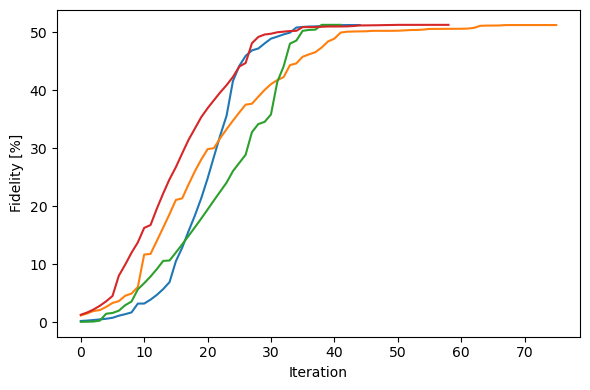

In [405]:
for i, opt_res in enumerate(ctrl_result.cost_history.iteration_values):
    plt.plot(1e2*(1-np.array(opt_res))) #, label=f'Trial {i}')
plt.xlabel('Iteration')
plt.ylabel('Fidelity [%]')
# plt.ylim(0, 1)
# plt.legend()
plt.tight_layout()
plt.show()

Convert controls dictionary into np arrays

In [347]:
# controls = dict()
# for q in range(len(qram.cutoffs)):
#     name = f'$\gamma_{q}$'
#     controls.update({name:result.output[name]})
# plot_controls(plt.figure(), controls, unit_symbol='GHz', polar=False)

Plot pi pulse qubit controls

In [377]:
times_pi = []
I_values_pi = []
Q_values_pi = []
qubits_pi = []
for q in range(qram.nqubits):
    I_values_q = []
    Q_values_q = []
    t = 0
    for j in range(2): # I, Q
        name = f"$\gamma{'I' if j==0 else 'Q'}_{q}$"
        control = ctrl_result.output[name]
        for step, pulse in enumerate(control):
            if q==0 and j==0: times_pi.append(t)
            t += pulse['duration']
            # factor of 1/2, -1, and 2pi due to how their controls are defined relative to ours
            if j==0: I_values_q.append(pulse['value'])
            else: Q_values_q.append(pulse['value'])
    I_values_pi.append(I_values_q)
    Q_values_pi.append(Q_values_q)
    qubits_pi.append(q)

times_pi = np.array(times_pi)
I_values_pi = np.array(I_values_pi)
Q_values_pi = np.array(Q_values_pi)
qubits_pi = np.array(qubits_pi)

I_values = I_values_pi
Q_values = Q_values_pi
times = times_pi
plt.figure(figsize=(6,8))
plt.suptitle('I, Q Controls (qubit drives)', fontsize=14)
ymax = 1.1*max(abs(np.concatenate((I_values.flatten(), Q_values.flatten()))))
for q in range(qram.nqubits):
    plt.subplot(int(f'41{q+1}'))
    plt.plot(times, 1e3*I_values[q], label=f'$I_{q}$')
    plt.plot(times, 1e3*Q_values[q], label=f'$Q_{q}$')
    plt.ylim(-1e3*ymax, 1e3*ymax)
    plt.ylabel(f'$\gamma_{q}/2\pi$ [MHz]')
    plt.legend()
plt.xlabel('Times [ns]')
plt.tight_layout()
plt.show()

KeyError: '$\\gammaI_0$'

Plot sideband controls

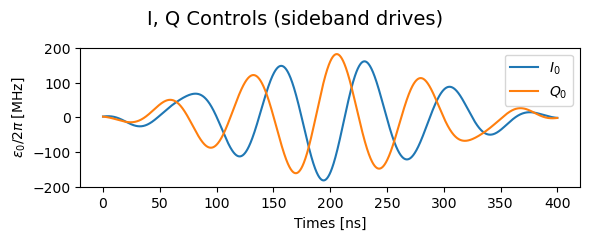

In [406]:
times_sb = []
I_values_sb = []
Q_values_sb = []
qubits_sb = []
for q in range(qram.nqubits):
    if q == 1: continue
    I_values_q = []
    Q_values_q = []
    t = 0
    for j in range(2): # I, Q
        name = f"$\epsilon{'I' if j==0 else 'Q'}_{q}$"
        control = ctrl_result.output[name]
        for step, pulse in enumerate(control):
            if q==0 and j==0: times_sb.append(t)
            t += pulse['duration']
            # factor of 1/2, -1, and 2pi due to how their controls are defined relative to ours
            if j==0: I_values_q.append(pulse['value'])
            else: Q_values_q.append(pulse['value'])
    I_values_sb.append(I_values_q)
    Q_values_sb.append(Q_values_q)
    qubits_sb.append(q)

times_sb = np.array(times_sb)
I_values_sb = np.array(I_values_sb)
Q_values_sb = np.array(Q_values_sb)
qubits_sb = np.array(qubits_sb)

I_values = I_values_sb
Q_values = Q_values_sb
times = times_sb
plt.figure(figsize=(6,8))
plt.suptitle('I, Q Controls (sideband drives)', fontsize=14)
ymax = 1.1*max(abs(np.concatenate((I_values.flatten(), Q_values.flatten()))))
for q in range(len(I_values)):
    plt.subplot(int(f'41{q+1}'))
    plt.plot(times, 1e3*I_values[q], label=f'$I_{q}$')
    plt.plot(times, 1e3*Q_values[q], label=f'$Q_{q}$')
    plt.ylim(-1e3*ymax, 1e3*ymax)
    plt.ylabel(f'$\epsilon_{q}/2\pi$ [MHz]')
    plt.legend()
plt.xlabel('Times [ns]')
plt.tight_layout()
plt.show()

Plotting qctrl state evolution

eg overlap 0.3656273756513707
gf overlap 0.38432095798828253
gg overlap 0.2500447518705564


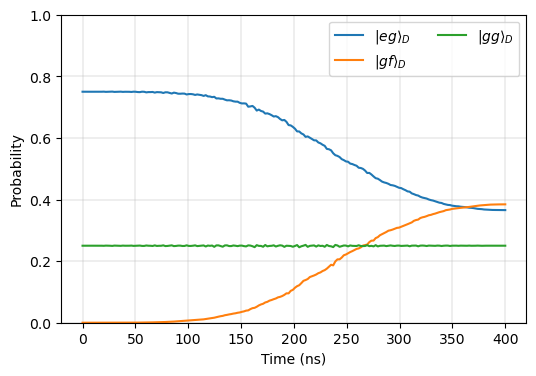

In [408]:
times = np.linspace(0, gate_duration, 200)

state_result = ctrl_result.output['sample_state']['value']
ref_states = ['eg', 'gf', 'gg']
for ref_state in ref_states:
    state = qram.state(ref_state)
    probs = [np.abs(state.overlap(qt.Qobj(state_result[t])))**2 for t in range(len(times))]
    print(ref_state, 'overlap', probs[-1])
    plt.plot(times, probs, label=f'$|{ref_state}\\rangle_D$')

# plt.plot(times, [0.5]*len(times), 'k--', linewidth=0.5)
plt.legend(ncol=2)
plt.ylim(0, 1)
# plt.xlim(750, 1000)
# plt.tick_params(labelsize=12)
plt.xlabel('Time (ns)')
plt.ylabel('Probability')
# plt.title(r'$\psi_0=|$'+psi0_name+r'$\rangle$')
# plt.title('QRAM state evolution in memory access operation')
plt.grid(linewidth=0.3)
plt.show()

# Simulate state evolution with optimal controls

In [409]:
seq = PulseSequence(start_time=0)

# for q in qubits_pi:
#     gstate = 'g'*qram.nqubits
#     estate = gstate[:q]+'e'+gstate[q+1:]
#     seq.const_pulse_IQ(wd=2*np.pi*qubit_freqs[q], amp=1, pulse_levels=[gstate, estate], I_values=I_values_pi[q], Q_values=Q_values_pi[q], times=times_pi, drive_qubit=q, t_start=0)

for q in qubits_sb:
    gstate = 'g'*qram.nqubits
    eg_state = gstate[:q]+'e'+gstate[q+1:]
    gf_state = gstate[:1]+'f'+gstate[2:]
    seq.const_pulse_IQ(wd=2*np.pi*freq_sb[q], amp=1, pulse_levels=[eg_state, gf_state], I_values=I_values_sb[q], Q_values=Q_values_sb[q], times=times_sb, drive_qubit=1, t_start=0)

In [410]:
# psi0_name = 'eggg'
# psi0_name = 'gfgg'
# psi0_name = 'efgg'
# psi0_name = 'eegg'
# psi0_name = 'ggeg'
# psi0_name = 'ggge'

# psi0 = qram.state(psi0_name)
psi0 = np.sqrt(0.25) * qram.state('gg') + np.sqrt(0.75) * qram.state('eg') # QRAM start
# psi0 = np.sqrt(0.25) * qram.state('eggg') + np.sqrt(0.75) * qram.state('eegg') # QRAM start
# psi0 = np.sqrt(0.25) * qram.state('gggg') + np.sqrt(0.75) * qram.state('gegg') # QRAM start

# print(seq.get_pulse_str())
times = np.linspace(0, gate_duration, 200)

start_time = time.time()
result = qram.evolve(psi0=psi0, seq=seq, times=times, c_ops=None, use_str_solve=False, nsteps=10000)
# result = qram.evolve_rot_frame(psi0, seq, times, c_ops=None, nsteps=20000)
print("Run time (s):", time.time() - start_time, flush=True)

10.0%. Run time:   3.55s. Est. time left: 00:00:00:31
20.0%. Run time:   7.07s. Est. time left: 00:00:00:28
30.0%. Run time:  10.87s. Est. time left: 00:00:00:25
40.0%. Run time:  14.82s. Est. time left: 00:00:00:22
50.0%. Run time:  18.87s. Est. time left: 00:00:00:18
60.0%. Run time:  23.11s. Est. time left: 00:00:00:15
70.0%. Run time:  27.29s. Est. time left: 00:00:00:11
80.0%. Run time:  31.46s. Est. time left: 00:00:00:07
90.0%. Run time:  35.46s. Est. time left: 00:00:00:03
Total run time:  39.10s
Run time (s): 39.098005056381226


#### Plotting for 2Q

eg overlap 0.30327887536106596
gf overlap 0.4455277432398221
gg overlap 0.25118485325159995


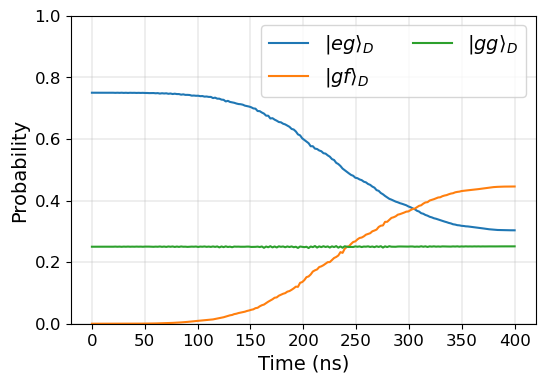

In [411]:
ref_states = ['eg', 'gf', 'gg']
for ref_state in ref_states:
    state = qram.state(ref_state)
    probs = [np.abs(state.overlap(result[t]))**2 for t in range(len(times))]
    print(ref_state, 'overlap', probs[-1])
    plt.plot(times, probs, label=f'$|{ref_state}\\rangle_D$')

# plt.plot(times, [0.5]*len(times), 'k--', linewidth=0.5)
plt.legend(fontsize=14, ncol=2)
plt.ylim(0, 1)
# plt.xlim(750, 1000)
plt.tick_params(labelsize=12)
plt.xlabel('Time (ns)', fontsize=14)
plt.ylabel('Probability', fontsize=14)
# plt.title(r'$\psi_0=|$'+psi0_name+r'$\rangle$')
# plt.title('QRAM state evolution in memory access operation')
plt.grid(linewidth=0.3)
plt.show()

#### Plotting for 4Q

In [ ]:
# states for 1 input
eggg = qram.state('eggg')
gfgg = qram.state('gfgg')
ggeg = qram.state('ggeg')
eegg = qram.state('eegg')
ggge = qram.state('ggge')
geeg = qram.state('geeg')
gege = qram.state('gege')
prob_eggg = [np.abs(eggg.overlap(result[t]))**2 for t in range(len(times))]
prob_gfgg = [np.abs(gfgg.overlap(result[t]))**2 for t in range(len(times))]
prob_ggeg = [np.abs(ggeg.overlap(result[t]))**2 for t in range(len(times))]
prob_eegg = [np.abs(eegg.overlap(result[t]))**2 for t in range(len(times))]
prob_ggge = [np.abs(ggge.overlap(result[t]))**2 for t in range(len(times))]
prob_geeg = [np.abs(geeg.overlap(result[t]))**2 for t in range(len(times))]
prob_gege = [np.abs(gege.overlap(result[t]))**2 for t in range(len(times))]

# states for 0 input
gggg = qram.state('gggg')
gegg = qram.state('gegg')
prob_gggg = [np.abs(gggg.overlap(result[t]))**2 for t in range(len(times))]
prob_gegg = [np.abs(gegg.overlap(result[t]))**2 for t in range(len(times))]


plt.plot(times, prob_eggg, label=r'$|eggg\rangle_D$')
plt.plot(times, prob_gfgg, label=r'$|gfgg\rangle_D$')
plt.plot(times, prob_ggeg, label=r'$|ggeg\rangle_D$')
plt.plot(times, prob_eegg, label=r'$|eegg\rangle_D$')
plt.plot(times, prob_ggge, label=r'$|ggge\rangle_D$')
plt.plot(times, prob_geeg, label=r'$|geeg\rangle_D$')
plt.plot(times, prob_gege, label=r'$|gege\rangle_D$')

# plt.plot(times, prob_gggg, label=r'$|gggg\rangle_D$')
# plt.plot(times, prob_gegg, label=r'$|gegg\rangle_D$')

# plt.plot(times, [np.abs(state('geeg').overlap(result[t]))**2 for t in range(len(times))], 'k--', label=r'$|geeg\rangle_D$')
# plt.plot(times, [np.abs(state('efgg').overlap(result[t]))**2 for t in range(len(times))], 'k-.', label=r'$|efgg\rangle_D$')

# for i1 in range(cutoffs[0]):
#     for i2 in range(cutoffs[1]):
#         for i3 in range(cutoffs[2]):
#             for i4 in range(cutoffs[3]):
#                 # print(qram.levels_nums_to_name([i1, i2, i3, i4]))
#                 plt.plot(times, 
#                          [np.abs(qram.state([i1, i2, i3, i4]).overlap(result[t]))**2 for t in range(len(times))],
#                          label='qram.level_nums_to_name[i1, i2, i3, i4]')

# plt.plot(times, [0.5]*len(times), 'k--', linewidth=0.5)
plt.legend(fontsize=16, ncol=2)
plt.ylim(0, 1)
# plt.xlim(750, 1000)
plt.tick_params(labelsize=14)
plt.xlabel('Time (ns)', fontsize=16)
plt.ylabel('Probability', fontsize=16)
# plt.title(r'$\psi_0=|$'+psi0_name+r'$\rangle$')
# plt.title('QRAM state evolution in memory access operation')
plt.grid(linewidth=0.3)
plt.show()

AssertionError: (12, 1) (108, 1)